# Assignment 5. Quantization for LLM


## Goals

본 실습에서는 대형 언어 모델(Large Language Model, LLM)에 대해 양자화(Quantization)을 수행하여 모델을 압축하는 방법을 실습합니다.

LLM은 파라미터의 개수가 매우 많기 때문에 일반적으로 FP16으로 관리합니다. 그럼에도 파라미터의 크기가 많이 크며, LLaMA-2 7B와 같이 작은 모델에 대해서도 모바일 환경에서 수행하고자 하는 경우 FP16에서도 최소 14GB 이상의 메모리를 요구하며 이는 실제로 돌리기에 무리가 있습니다. 따라서, 양자화를 통해 모델의 weight를 더 낮은 precision으로 압축하는 것이 가능합니다.

## Contents
1. Weight-only Quantization
  - Weight만 quantization을 적용합니다.
  - 장점: 매우 낮은 bit-width로 weight를 양자화할 수 있으며, 단일 배치 추론 환경에서 유리합니다.
  - 단점: Dequantization 후 FP16 연산을 수행해야 합니다.
  - 예시: AWQ (W3A16, W4A16)
2. Weight and Activation Quantization
  - Weight와 activation 모두 quantization을 적용합니다.
  - 장점: 낮은 precision의 연산을 통해 가속 가능하며, 대규모 배치 추론 환경에서 유리합니다.
  - 단점: weight의 bit-width를 낮추기에 한계가 존재합니다.
  - 예시: SmoothQuant (W8A8)

## Setup

실습에 필요한 패키지를 설치합니다.

In [66]:
print("Setting up environment...")

# 패키지 설치
# !pip install -q torch transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3 datasets==2.15.0 tqdm zstandard huggingface-hub==0.27.0

# 데이터 다운로드
!mkdir -p /content/data
!curl -sL https://huggingface.co/datasets/mit-han-lab/pile-val-backup/resolve/main/val.jsonl.zst -o /content/data/val.jsonl.zst

# 환경 변수 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_HOME"] = "/content/hf_cache"
datapath = "/content/data/val.jsonl.zst"

weights_path = "opt_125m_weights.pth"
weights_url = "https://www.dropbox.com/scl/fi/mumd3abnbhyz03v0bopn8/opt_125m_weights.pth?rlkey=lo8gaw3axn8o9i8sw0kivxfwx&st=onxynbq2&dl=1"

if not os.path.exists(weights_path):
    print(f"Downloading weights from {weights_url}...")
    # curl -L -o [저장파일명] [URL] ('dl=1'로 변경하여 직접 다운로드)
    os.system(f"curl -L -o {weights_path} '{weights_url}'")
    print("Download complete.")
else:
    print("Weights file already exists.")

print("Environment ready.")

Setting up environment...
Weights file already exists.
Environment ready.


실습에 필요한 모듈을 로드합니다.

In [67]:
import torch
import gc
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from functools import partial
from matplotlib.colors import Normalize
from transformers.models.opt.modeling_opt import OPTDecoderLayer
from transformers.models.bloom.modeling_bloom import BloomBlock
from transformers.models.llama.modeling_llama import LlamaDecoderLayer, LlamaRMSNorm

다음 코드는 모델 크기를 계산하는 데 사용됩니다.

In [68]:
class LLMModel:
    """
    대형언어모델(LLM)의 평가 및 관리 클래스.
    """

    def __init__(self, model_name, weights_path=None):
        self.model_name = model_name
        self.weights_path = weights_path

        if (self.weights_path != None):
            self._load_model_from_weights()
        else:
            # 사전학습된 언어모델 로드
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                torch_dtype=torch.float16,
                use_safetensors=True
            )
            self.model.eval()  # 평가 모드 설정 (dropout 비활성화)

        # 토크나이저 로드 (토크나이저는 아키텍처와 세트이므로 from_pretrained 유지)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

        # 평가용 데이터셋 로드 (WikiText-2)
        testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
        testenc = self.tokenizer("\n\n".join(testenc['text']), return_tensors='pt')
        self.testenc = testenc.input_ids.to(self.model.device)

        self.model_changed = False

    def _load_model_from_weights(self):
        print(f"Loading model architecture: {self.model_name}")
        config = AutoConfig.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_config(config)

        print(f"Loading weights from: {self.weights_path}")
        checkpoint = torch.load(self.weights_path, map_location="cpu")

        # --- [수정] state_dict 키 확인 및 추출 로직 추가 ---
        if "state_dict" in checkpoint:
            state_dict = checkpoint["state_dict"]
        else:
            state_dict = checkpoint

        try:
            self.model.load_state_dict(state_dict)
        except RuntimeError as e:
            print("Error loading state_dict directly. Attempting strict=False...")
            print(e)
            self.model.load_state_dict(state_dict, strict=False)

        self.model.to(dtype=torch.float16)
        self.model.cuda()
        self.model.eval()

    def _evaluate(self):
        nsamples = 100
        nlls = []

        for i in tqdm(range(nsamples), desc="evaluating..."):
            batch = self.testenc[:, (i * 2048):((i + 1) * 2048)].to(self.model.device)
            with torch.no_grad():
                lm_logits = self.model(batch).logits

            shift_logits = lm_logits[:, :-1, :].contiguous().float()
            shift_labels = self.testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            neg_log_likelihood = loss.float() * 2048
            nlls.append(neg_log_likelihood)

        return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

    def get_model_size(self, data_width=16, group_size=-1):
        if group_size != -1:
            data_width += (16 + 4) / group_size
        num_elements = sum(param.numel() for param in self.model.parameters())
        return num_elements * data_width

    def model_delete(self):
        del self.model
        gc.collect()
        torch.cuda.empty_cache()

    def model_evaluate(self, data_width, group_size):
        model_perplexity = self._evaluate()
        model_size = self.get_model_size(data_width=data_width, group_size=group_size)

        print(f"\nmodel perplexity: {model_perplexity:.2f}")
        print(f"model size: {model_size / 1024 / 1024 / 8:.2f} MiB")
        return model_perplexity

    def model_reset(self):
        """
        모델이 변경된 경우 초기 가중치 파일로 재설정
        """
        if self.model_changed:
            self.model_delete()
            # 초기 로드 로직 재사용
            if (self.weights_path != None):
                self._load_model_from_weights()
            else:
                # 사전학습된 언어모델 로드
                self.model = AutoModelForCausalLM.from_pretrained(
                    self.model_name,
                    device_map="auto",
                    torch_dtype=torch.float16,
                    use_safetensors=True
                )
                self.model.eval()  # 평가 모드 설정 (dropout 비활성화)
            self.model_changed = False

    def model_change(self, model: nn.Module):
        self.model_delete()
        self.model = model
        self.model.eval()
        self.model_changed = True

먼저 FP32 모델의 혼란도(perflexity)와 모델 크기를 평가해봅시다.

LLaMA-65B 모델의 디코딩 단계에서 단일 배치 추론을 수행할 때, 우리는 $[1, 8192] \times [8192, 8192]$ 형태의 GEMV(General Matrix-Vector Multiplication)연산을 수행해야 합니다.

NVIDIA A100 80G의 경우, **half-precision(FP16)** 에서의 성능은 312TFLOPS이며, memory bandwidth는 약 2000GB/s 입니다. 이를 바탕으로, **계산 집약도(computation intensity)** 를 계산할 수 있습니다:

$$
\frac{\text{FLOP}}{\text{Byte}} = \frac{2\times 8192^2}{8192^2} << \frac{3.12\times 10^{11}}{2\times 10^9}
$$

이는 매우 메모리 제약적(Memory-bounded)(~$10^2$ gap)으로, 저비트 가중치 양자화가 필요한 이유입니다.

In [69]:
model_path = "facebook/opt-125m"
# LLMModel 인스턴스 생성 시 가중치 파일 경로도 함께 전달 (위에서 정의한 weights_path)
llm_model = LLMModel(model_path, weights_path)

# Evaluate the model
llm_model.model_evaluate(data_width=32, group_size=128)

Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:04<00:00, 20.64it/s]


model perplexity: 27.74
model size: 480.08 MiB


tensor(27.7379, device='cuda:0')

# 4.1. Weight-only Quantization (AWQ)

AWQ (activation aware weight only quantization)

대형 언어 모델(LLM)은 다양한 작업에서 뛰어난 성능을 보여주고 있지만, 엄청난 모델 크기로 인해 하드웨어적 장벽(메모리 크기)이 높아지고, 토큰 생성 속도가 느려집니다(메모리 대역폭). LLM의 크기와 계산량은 기하급수적으로 증가하고 있는 반면, 메모리 대역폭은 느리게 증가하고 있습니다. 이 격차는 LLM 성능에서 중요한 병목 현상입니다. 이번 실습에서는 **새로운 양자화 알고리즘(AWQ)**을 사용하여 LLM의 메모리 사용량을 줄이고 추론 속도를 가속화하는 방법을 탐구할 것입니다.

## AWQ


Uniform quantization 은 실수 값을 range $[\beta, \alpha]$에서 $[0, 2^{b} - 1]$로 매핑하는 것입니다.

Notation:

- Quantized Weight: $w_q$

- Scale factor: $s_q$

- Zero Point: $z$
\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}

\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2}
\end{equation}

\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



## Pseudo Quantization
아래 코드는 의사 양자화(pseudo quantization)을 위한 것입니다.


Pseudo Quantization는 모델의 가중치를 실제로 양자화하지 않고, 양자화의 영향을 시뮬레이션하기 위해 사용됩니다. (즉, 가장 가까운 양자화된 값으로 반올림한 다음, **다시 부동 소수점으로 복원(dequantizing)하는** 것입니다.)

In [70]:
# 핵심 양자화 함수 (simulated quantization, 즉 실제 비트 축소 없이 효과만 모사)
def pseudo_quantize_tensor(w, n_bit=4, q_group_size=-1):
    org_w_shape = w.shape
    # 그룹 단위 양자화 적용 시 weight 행렬을 그룹 크기로 재구성
    if q_group_size > 0:
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)

    assert w.dim() == 2

    # 각 행(또는 그룹)별 최대값(α)과 최소값(β) 계산
    max_val = w.amax(dim=1, keepdim=True)
    min_val = w.amin(dim=1, keepdim=True)

    # 스케일(scale)과 제로포인트(zero point) 계산
    # scale = (α - β) / (2^n_bit - 1)
    # zero = round(-β / scale)
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int)

    # NaN 검증
    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # 양자화(Quantization) 단계: 실수값을 정수 범위 [0, 2^n_bit - 1]로 매핑
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int)

    # 복원 단계(Dequantization): 정수값을 다시 실수 범위로 변환 (pseudo quantization)
    w = (w - zeros) * scales

    # NaN 검증
    assert torch.isnan(w).sum() == 0

    # 원래 텐서 형태로 복원
    w = w.reshape(org_w_shape)
    return w


@torch.no_grad()
def pseudo_quantize_model_weight(model, w_bit, q_group_size):
    # 모델 내 Linear 계층의 weight만 선택적으로 pseudo quantization 적용
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(
                m.weight.data, n_bit=w_bit, q_group_size=q_group_size
            )

이제 quantized 3-bit 모델의 혼란도(perplexity)와 크기를 평가해 봅시다.

In [71]:
llm_model.model_reset()
pseudo_quantize_model_weight(llm_model.model, w_bit=3, q_group_size=128)
llm_model.model_changed = True

# Evaluate the model
llm_model.model_evaluate(data_width=3, group_size=128)

evaluating...: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


model perplexity: 62.89
model size: 47.12 MiB


tensor(62.8900, device='cuda:0')

모델 크기가 줄어든 것은 확인할 수 있지만, 혼란도(perplexity)는 상당히 증가했습니다.

논문에서의 관찰에 따르면 LLM의 활성화(activations)에서 일부 채널에 **아웃라이어(outliers)**가 소량 발생하고 있습니다. 특정 채널에 아웃라이어가 있는 경우, 이는 **모든 토큰에서 지속적으로 나타납니다.**

주어진 토큰에 대한 채널 간의 분산(variance)은 크지만(일부 채널의 활성화는 매우 크고, 대부분은 작습니다), 특정 채널의 크기(magnitude)가 토큰 간에 가지는 분산은 작습니다(아웃라이어 채널은 지속적으로 큽니다).


AWQ(Activation Aware Weight Quantization)의 기법에 따르면, 활성화(activation) 아웃라이어에 해당하는 가중치 채널은 더 두드러지며, 이러한 두드러진 가중치를 보존하는 것이 성능 향상으로 이어질 수 있습니다. 다음으로, 두드러진 가중치를 찾고 원래 값으로 유지하여 혼란도(perplexity)의 변화를 관찰해 보겠습니다.

아래 코드는 calibration 데이터셋을 로드하여 활성화 아웃라이어를 얻고 두드러진 가중치를 식별하는 데 사용됩니다.

In [72]:
def get_calib_dataset(tokenizer=None, n_samples=256, block_size=512):
    dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
    dataset = dataset.shuffle(seed=42)

    samples = []
    n_run = 0

    # n_samples 만큼 문장을 토크나이즈하여 샘플 생성
    for data in dataset:
        line = data["text"].strip()
        line_encoded = tokenizer.encode(line)

        # 너무 긴 문장은 제외
        if len(line_encoded) > block_size:
            continue

        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue

        samples.append(sample)
        n_run += 1

        # 설정된 개수만큼 샘플 수집 완료 시 종료
        if n_run == n_samples:
            break

    # 모든 샘플을 연결 후 block_size 단위로 나눔
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")

    # block_size 단위로 분할된 텐서 리스트 반환
    return [cat_samples[:, i * block_size:(i + 1) * block_size] for i in range(n_split)]


@torch.no_grad()
def get_calib_feat(model, tokenizer):
    # 각 Linear layer의 입력 활성값(activation) 통계를 수집하기 위한 훅 등록용 dict
    input_dict = dict()

    # forward hook 함수: layer 입력의 평균 절댓값(activation scale)을 계산
    def stat_input_max_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        # 입력 텐서를 (batch*seq_len, hidden_dim) 형태로 reshape 한 뒤,
        # hidden_dim 방향으로 평균 절댓값 계산 → activation scale 추정
        x_max = x.view(-1, x.shape[-1]).abs().mean(dim=0).cpu().detach()

        # 레이어별로 통계 누적
        if name not in input_dict:
            input_dict[name] = [x_max]
        else:
            input_dict[name] += [x_max]

    hooks = []
    # 모든 Linear layer에 대해 forward hook 등록
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook, name=name)
                )
            )

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # calibration용 입력 데이터셋 생성
    samples = get_calib_dataset(tokenizer)
    pbar = tqdm(samples)

    # 각 샘플을 모델에 통과시키며 hook으로 입력 통계 수집
    for input_ids in pbar:
        input_ids = input_ids.to(device)
        model(input_ids)

    # hook 해제
    for hook in hooks:
        hook.remove()

    # 레이어별 입력 통계(activation scale) 반환
    return input_dict

In [73]:
llm_model.model_reset()
input_feat = get_calib_feat(llm_model.model, llm_model.tokenizer)

Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


Repo card metadata block was not found. Setting CardData to empty.


 * Split into 127 blocks


100%|██████████| 127/127 [00:02<00:00, 52.44it/s]


127
torch.Size([768])


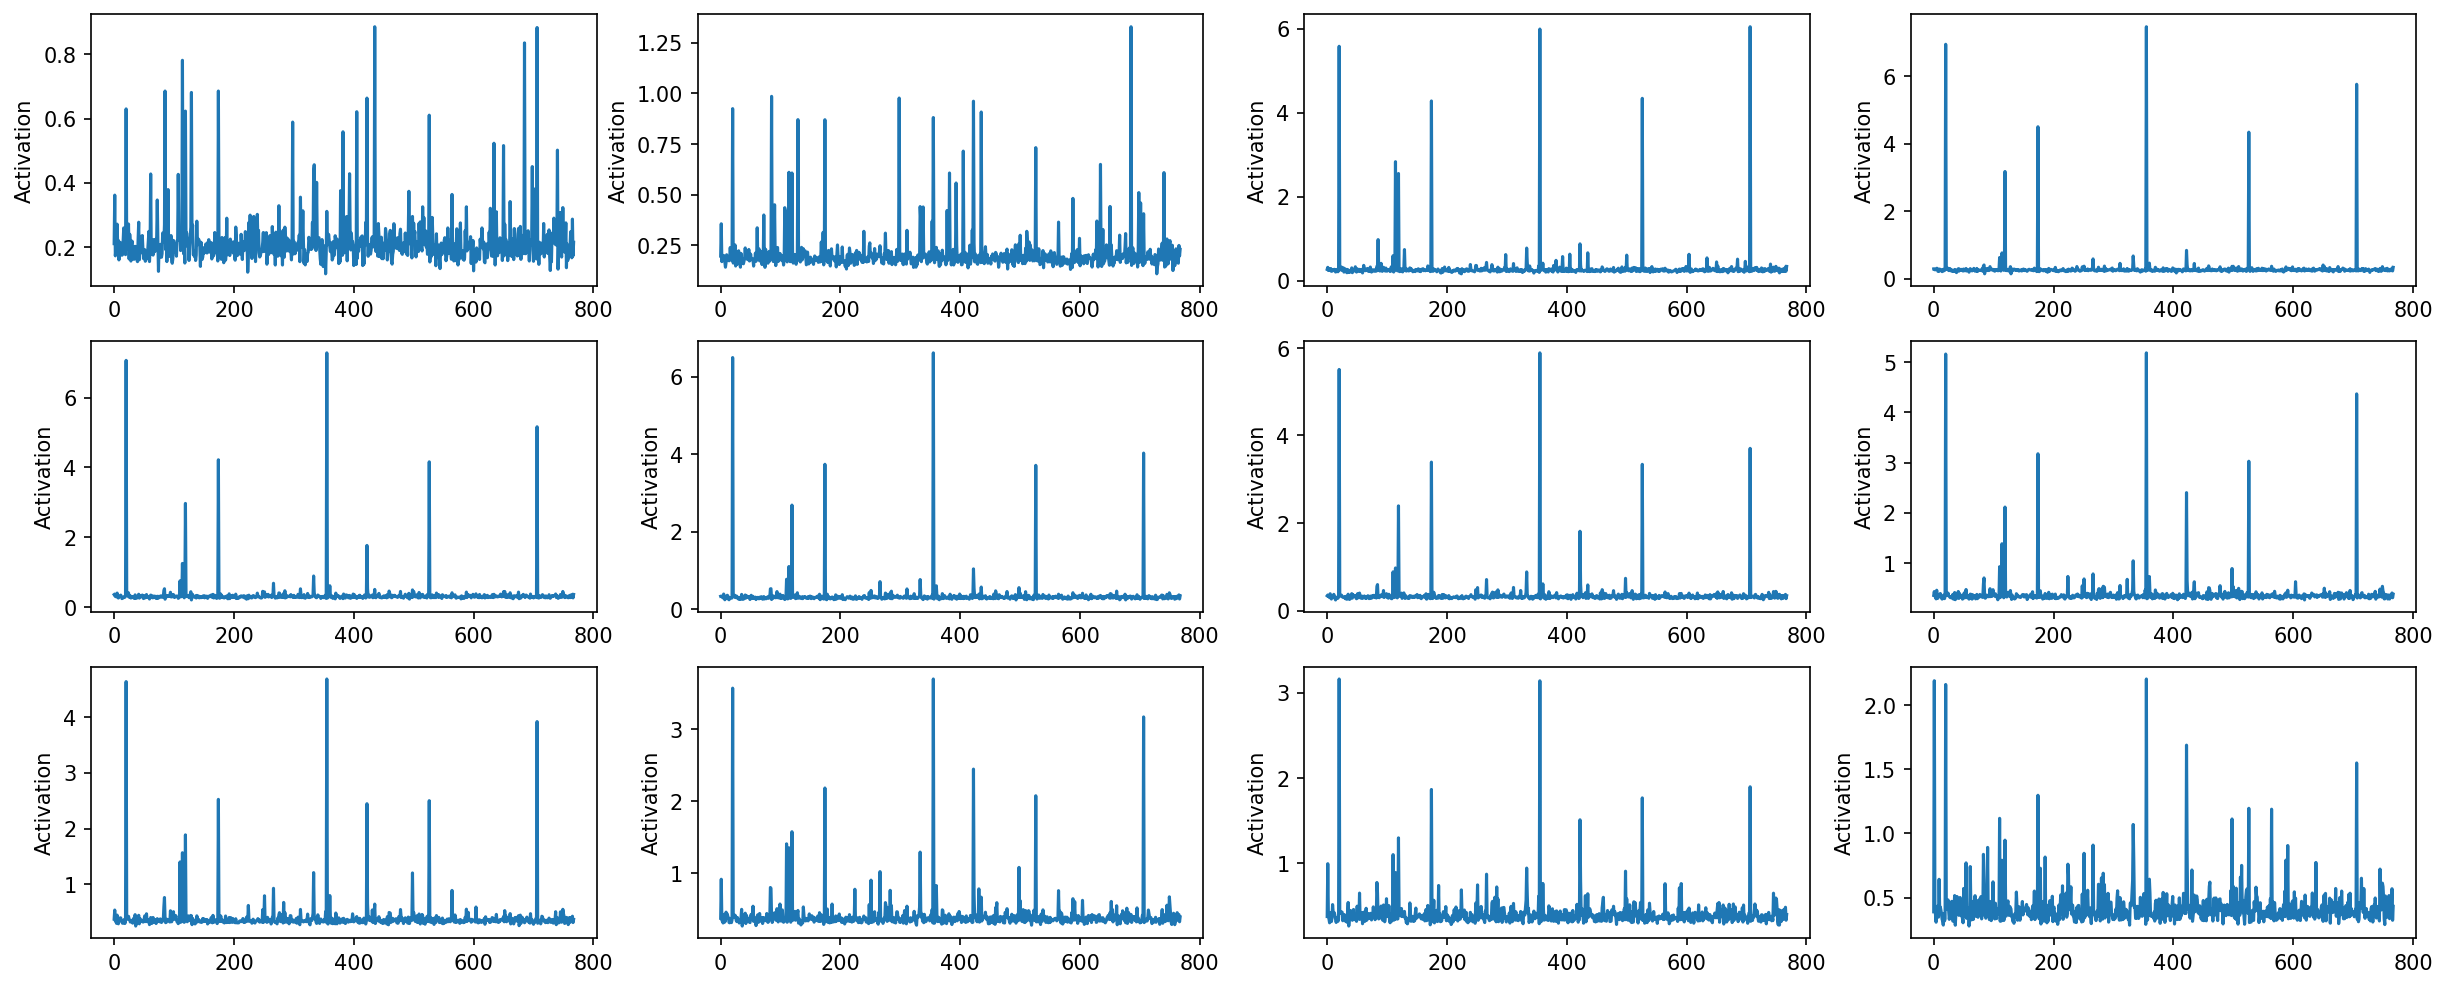

In [74]:
print(len(input_feat['model.decoder.layers.0.self_attn.q_proj']))
print(input_feat['model.decoder.layers.0.self_attn.q_proj'][0].shape)

plt.figure(figsize=(20, 8), dpi=150)

for i, layer_idx in enumerate(range(12)):
  plt.subplot(3, 4, i+1)
  plt.plot(input_feat[f'model.decoder.layers.{layer_idx}.self_attn.q_proj'][0])
  plt.ylabel("Activation")
plt.show()

# [실습 1] Scale 1% salient channels

1%의 가중치를 FP16으로 유지하면 모델 크기(총 비트 수로 측정)를 크게 늘리지 않고도 양자화 성능을 향상시킬 수 있지만, 이러한 혼합 정밀도 데이터 유형은 시스템 구현을 어렵게 만듭니다.

따라서 중요한 가중치를 실제로 FP16으로 유지하지 않고 중요한 가중치를 보호할 수 있는 방법을 찾아야 합니다.

AWQ의 방법론에 따르면, 중요한 가중치 채널을 단순히 스케일링하여(특정한 값을 곱해 주어) 보호할 수 있습니다. 원리는 다음과 같습니다:

- Linear layer channel $\mathbf{y} = \mathbf{w}x$ (from $\mathbf{W}x$)일 때, 우리가 주목해야 할 것은 양자화 함수 $Q(\mathbf{w})x$으로 발생하는 quantization error입니다.

- Quantization function $Q(\mathbf{w})$ = $Δ\cdot Round(\frac{\mathbf{w}}{Δ})$, $Δ = \frac{\max(|w|)}{2^{N - 1}}$.

- Quantization error $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$
- 스케일링 된  Quantization error $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$.
- $RoundErr$ 는 언제나 ~0.25 입니다 (0-0.5 사이의 평균이므로).
- 그룹의 크기가 충분히 클 때(e.g., 128), 하나의 채널을 스케일링하는 것은 일반적으로 그룹 내 최대 값을 증가시키지 않습니다 (즉, $Δ$ 는 변하지 않습니다).
- 그러므로, $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$ < $Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x = Err(Q(\mathbf{w}) x)$.

아래 코드를 완성하여 중요한 가중치 채널을 스케일링하고, 양자화 한 다음, 다시 스케일을 줄인 후 혼란도(perplexity)의 변화를 관찰해보세요.

In [75]:
@torch.no_grad()
def pseudo_quantize_model_weight_scaleup(
    model, w_bit, q_group_size, input_feat, scale_factor
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()
            # 1퍼센트 채널의 개수
            num_samples = int(len(importance) * 0.01)

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: importance를 기준으로 1%의 중요한 채널을 찾으세요  (hint: use torch.topk())
            # hint : torch.topk() 함수를 사용하세요. torch.topk() 함수는 PyTorch에서 텐서의 값 중 상위 k개의 값과 그들의 인덱스를 반환하는 함수입니다. torch.topk()[0]는 값을, torch.topk()[1]은 인덱스를 반환합니다.
            outlier_mask = torch.topk(importance, int(len(importance) * 0.01))[1]

            ############### YOUR CODE ENDS HERE #################
            assert outlier_mask.dim() == 1

            # 스케일 팩터를 적용하는 것을 시뮬레이션하기 위해, 양자화 전에 스케일 팩터를 곱하고, 양자화 후에 스케일 팩터로 나눕니다.
            # scale_factor를 이용해 중요한 가중치 채널의 값을 확대합니다.
            m.weight.data[:, outlier_mask] *= scale_factor

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: scale_factor를 이용해 중요한 가중치 채널의 값을 다시 축소하세요.
            m.weight.data[:, outlier_mask] /= scale_factor

            ############### YOUR CODE ENDS HERE #################

스케일링을 통해서 중요한 가중치를 보호함과 동시에, 모든 가중치를 3bit로 유지할 수 있었습니다.

In [76]:
for scale_factor in [1, 1.5, 2, 2.5, 3]:
    print(f"=========== Scale_factor : {scale_factor} ===========")
    llm_model.model_reset()
    pseudo_quantize_model_weight_scaleup(llm_model.model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=scale_factor)
    llm_model.model_changed = True

    # Evaluate the model
    llm_model.model_evaluate(data_width=3, group_size=128)

=========== Scale_factor : 1 ===========


evaluating...: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]



model perplexity: 62.89
model size: 47.12 MiB
=========== Scale_factor : 1.5 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:04<00:00, 24.50it/s]



model perplexity: 51.79
model size: 47.12 MiB
=========== Scale_factor : 2 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:04<00:00, 24.50it/s]



model perplexity: 52.20
model size: 47.12 MiB
=========== Scale_factor : 2.5 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:04<00:00, 24.46it/s]



model perplexity: 62.02
model size: 47.12 MiB
=========== Scale_factor : 3 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:04<00:00, 24.26it/s]


model perplexity: 71.59
model size: 47.12 MiB


코드에서 서로 다른 스케일링 팩터 $s$(예: 1, 2, 3, 4)를 시도하고 혼란도(perplexity)의 변화를 관찰해보세요.

혼란도(perplexity)가 먼저 감소하다가 다시 증가하는 것을 관찰했나요?

너무 큰 팩터로 스케일링하면 그룹 내 최대 값이 증가할 수 있습니다(즉,$Δ$가 증가함).

이는 다른 채널의 양자화에 영향을 미칠 수 있습니다.

# [실습 2] Scale factor search

지금까지 우리는 스케일링 팩터$s$를 직접 정의해 주었습니다.

그러나 Fine-tuning의 불안정성 때문에, 미리 정의된 검색 공간 내에서 최적의
$s$를 찾는 것이 더 나은 선택이 될 것입니다. 우리는 중요한 가중치를 보호하면서 다른 값을 고려하기 위해 검색 공간 내에서 최적의 스케일을 찾을 수 있습니다.

실제로, 논문에서는 활성화만 고려하는 것으로도 좋은 결과를 얻을 수 있음을 관찰할 수 있습니다.

우리는 스케일링 팩터 $s$를 활성화의 L1-norm (즉, acviation matrix의 절댓값들의 평균)의 $\alpha$제곱으로 설정할 것입니다.

$\alpha$의 값은 grid search를 통해 적절한 값으로 검색합니다.

검색을 위한 코드를 추가하고 실행하여 혼란도(perplexity)를 관찰하세요.

$$
𝐋(\mathbf{s})=\lVert Q(\mathbf{W}\cdot \mathbf{s})  (\mathbf{s^{-1}} \cdot \mathbf{X}) - \mathbf{W}\mathbf{X}  \rVert,  \quad\mathbf{s}= \mathbf{s_X}^{\alpha},  \mathbf{s_X} = \|X\|_1
$$
$$
\mathbf{s}^* = \text{argmin}_{\mathbf{s}} 𝐋(\mathbf{s}),\quad \alpha^*=\text{argmin}_{\alpha} 𝐋(\mathbf{s_X}^{\alpha})
$$

In [77]:
@torch.no_grad()
def scale_ln_fcs(ln, fcs, scales):
    """
    LayerNorm(LN)과 그 다음에 연결된 Linear layer(fc)들의 파라미터 스케일을 조정
    """
    # fc가 단일 레이어일 경우 리스트로 변환
    if not isinstance(fcs, list):
        fcs = [fcs]

    # scale 텐서를 LN의 디바이스로 이동
    scales = scales.to(ln.weight.device)

    # LayerNorm 파라미터 스케일 조정
    # scale factor로 나누어 normalization 강도를 맞춤
    ln.weight.div_(scales)
    if hasattr(ln, 'bias') and ln.bias is not None:
        ln.bias.div_(scales)

    # 후속 Linear layer의 입력 스케일을 보정
    # LN 출력이 작아지면, fc 입력 가중치를 동일 비율로 키워서 feature scale 균형 유지
    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))

    # NaN 검증 (안정성 체크)
    for p in ln.parameters():
        assert torch.isnan(p).sum() == 0
    for fc in fcs:
        for p in fc.parameters():
            assert torch.isnan(p).sum() == 0


@torch.no_grad()
def scale_fc_fc(fc1, fc2, scales):
    """
    두 개의 연속된 Linear layer(fc1 → fc2) 간의 스케일을 조정
    """
    assert isinstance(fc1, nn.Linear)
    assert isinstance(fc2, nn.Linear)

    scales = scales.to(fc1.weight.device)

    # fc1의 출력 채널 방향으로 스케일 보정
    # 주석된 라인은 전체 weight에 적용하는 방식 (현재는 마지막 부분만 적용)
    fc1.weight[-scales.size(0):].div_(scales.view(-1, 1))

    # bias가 존재할 경우 동일하게 보정
    if fc1.bias is not None:
        fc1.bias.div_(scales.view(-1))

    # fc2의 입력 채널 방향으로 스케일을 곱해 normalization 후 feature scale 복원
    fc2.weight.mul_(scales.view(1, -1))

    # NaN 검증 (안정성 체크)
    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in fc2.parameters():
        assert torch.isnan(p).sum() == 0


In [78]:
@torch.no_grad()
def auto_scale_block(module, name, w_bit,
                     q_group_size,
                     input_feat):

    # find the best scale ratio
    def _search_module_scale(block, linears2scale: list, x, kwargs={}):

        x = x.to(next(block.parameters()).device)
        with torch.no_grad():
            org_out = block(x, **kwargs)
            if isinstance(org_out, tuple):
                org_out = org_out[0]

        s_x = x.view(-1, x.shape[-1]).abs().mean(0)
        s_x = torch.clamp(s_x, 1e-5)


        # Step 1: best_error, best_ratio, 및 best_scales를 초기화
        best_error = torch.inf
        best_ratio = -1
        best_scales = 0


        n_grid = 20
        history = []

        org_sd = {k: v.cpu() for k, v in block.state_dict().items()}
        for ratio in range(n_grid):
            # ratio is the \alpha in the formula
            ratio = ratio * 1 / n_grid

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: 공식에 따라 스케일 계산
            scales = s_x ** ratio

            ############### YOUR CODE ENDS HERE #################
            assert scales.shape == s_x.shape

            scales = scales / (scales.max() * scales.min()).sqrt().view(1, -1)

            for fc in linears2scale:

                scales = scales.to(fc.weight.device)

                ############### YOUR CODE STARTS HERE ###############

                # Step 3: scale_factor를 이용해 중요한 가중치 채널의 값을 확대합니다.
                fc.weight.data *= scales

                fc.weight.data = pseudo_quantize_tensor(fc.weight.data, w_bit, q_group_size)

                # Step 4: scale_factor를 이용해 중요한 가중치 채널의 값을 다시 축소하세요.
                fc.weight.data /= scales

                ############### YOUR CODE ENDS HERE #################

            out = block(x, **kwargs)
            if isinstance(out, tuple):
                out = out[0]

            loss = (org_out - out).float().pow(2).mean().item()  # float prevents overflow
            history.append(loss)
            is_best = loss < best_error
            if is_best:
                best_error = loss
                best_ratio = ratio
                best_scales = scales
            block.load_state_dict(org_sd)

        if best_ratio == -1:
            print(history)
            raise Exception

        best_scales = best_scales.view(-1)

        assert torch.isnan(best_scales).sum() == 0, best_scales
        return best_scales.detach()

    # (1) Self-Attention 입력 부분 (Q, K, V projection)
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    qkv = [module.self_attn.q_proj, module.self_attn.k_proj, module.self_attn.v_proj]
    final_scales = _search_module_scale(module.self_attn, qkv, inp)
    scale_ln_fcs(module.self_attn_layer_norm, qkv, final_scales)

    # (2) Self-Attention 출력 부분 (out_proj)
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.self_attn.out_proj, [module.self_attn.out_proj], inp)
    scale_fc_fc(module.self_attn.v_proj, module.self_attn.out_proj, final_scales)

    # (3) Feed-Forward Network 첫 번째 FC (fc1)
    inp = input_feat[name + '.fc1']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc1, [module.fc1], inp)
    scale_ln_fcs(module.final_layer_norm, module.fc1, final_scales)

    # (4) Feed-Forward Network 두 번째 FC (fc2)
    inp = input_feat[name + '.fc2']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc2, [module.fc2], inp)
    scale_fc_fc(module.fc1, module.fc2, final_scales)

@torch.no_grad()
def pseudo_quantize_model_weight_auto_scale(model, w_bit, q_group_size, input_feat):
    """
    OPT 계열 모델 전체에 대해 자동 스케일 조정(auto-scale) 기반 pseudo quantization 수행.
    각 Decoder Layer 단위로 auto_scale_block을 적용.
    """
    from transformers.models.opt.modeling_opt import OPTDecoderLayer

    # 각 OPTDecoderLayer(Transformer 블록)에 대해 auto scaling 수행
    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            auto_scale_block(module, name, w_bit, q_group_size, input_feat)

    # 모든 Linear layer에 pseudo quantization 최종 적용
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(
                m.weight.data, n_bit=w_bit, q_group_size=q_group_size
            )

In [79]:
llm_model.model_reset()
pseudo_quantize_model_weight_auto_scale(llm_model.model, w_bit=3, q_group_size=128, input_feat=input_feat)
llm_model.model_changed = True

# Evaluate and delete the model
llm_model.model_evaluate(data_width=3, group_size=128)

Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


model perplexity: 51.76
model size: 47.12 MiB


tensor(51.7619, device='cuda:0')

# 4.2. Weight and Activation Quantization

대형 언어 모델(LLM)은 다양한 작업에서 뛰어난 성능을 보여주고 있지만, 엄청난 모델 크기로 인해 하드웨어적 장벽(메모리 크기)이 높아지고, 토큰 생성 속도가 느려집니다(메모리 대역폭). LLM의 크기와 계산량은 기하급수적으로 증가하고 있는 반면, 메모리 대역폭은 느리게 증가하고 있습니다. 이 격차는 LLM 성능에서 중요한 병목 현상입니다. 이번 실습에서는 **새로운 양자화 알고리즘(AWQ)**을 사용하여 LLM의 메모리 사용량을 줄이고 추론 속도를 가속화하는 방법을 탐구할 것입니다.

이전 수업에서는 양자화(Quantization)의 기본 방법들을 배웠습니다.

양자화에는 두 가지 유형이 있습니다:

- 가중치(weight)와 활성화(activation) 모두 양자화
    - 계산 한계가 있는 시나리오에서 더 유리합니다: 예를 들어 컨텍스트 단계나 대규모 배치 추론
    - 예시: SmoothQuant(W8A8 quantization)
- 가중치(weight)만 양자화
    - 메모리 한계가 있는 시나리오에서 더 유리합니다: 예를 들어 디코딩 단계나 단일 배치 추론.
    - 예시: AWQ(W4A16 quantization)

이 노트북에서는 OPT-125m 모델을 사용하여 SmoothQuant가 가중치와 활성화 모두에 8비트를 사용하여 FP16 모델과 동일한 정확도를 달성할 수 있음을 보여줍니다. SmoothQuant는 Linear layer에서 완전한 INT8 GEMM을 가능하게 하고, 이상값을 나타내기 위해 고정밀도 숫자를 요구하지 않습니다.

Uniform quantization 은 실수 값을 range$[\beta, \alpha]$에서 $[0, 2^{b} - 1]$로 매핑하는 것입니다.

Notation:

- Quantized Weight: $w_q$

- Scale factor: $s_q$

- Zero Point: $z$
\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}
\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2}
\end{equation}
\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



## Pseudo Quantization
아래 코드는 의사 양자화(pseudo quantization)을 위한 클래스입니다.

Pseudo Quantization는 모델의 weight와 activation을 실제로 양자화하지 않고, 양자화의 영향을 시뮬레이션하기 위해 사용됩니다. (즉, 가장 가까운 양자화된 값으로 반올림한 다음, **다시 부동 소수점으로 복원(dequantizing)**하는 것입니다.)

이 노트북에서는 실제 연산에서는 FP16을 사용하여 8비트 dynamic weight and activation qaunitzation을 시뮬레이션 합니다.

In [80]:
class W8A8Linear(nn.Module):
    """
    8-bit Weight(A) × 8-bit Activation(A) 양자화 시뮬레이션용 Linear Layer.
    실제 연산은 FP16으로 수행되지만, 연산 전후에 quantize/dequantize 단계를 통해
    8-bit 정밀도의 효과를 모사
    """

    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        act_quant="per_token",
        quantize_output=False,
        quantize_bits=8
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Weight 초기화 (FP16)
        self.register_buffer(
            "weight",
            torch.randn(
                self.out_features,
                self.in_features,
                dtype=torch.float16,
                requires_grad=False,
            ),
        )

        # Bias 초기화 (FP16)
        if bias:
            self.register_buffer(
                "bias",
                torch.zeros(
                    (1, self.out_features), dtype=torch.float16, requires_grad=False
                ),
            )
        else:
            self.register_buffer("bias", None)

        # 입력 activation quantization 방식 선택
        # per_token: 토큰별로 스케일 계산
        # per_tensor: 전체 텐서 단위로 스케일 계산
        if act_quant == "per_token":
            self.act_quant_name = "per_token"
            self.act_quant = partial(quantize_activation_per_token_absmax, n_bits=8)
        elif act_quant == "per_tensor":
            self.act_quant_name = "per_tensor"
            self.act_quant = partial(quantize_activation_per_tensor_absmax, n_bits=8)
        else:
            raise ValueError(f"Invalid act_quant: {act_quant}")

        # 출력 activation quantization 옵션 (예: BMM 입력용)
        if quantize_output:
            self.output_quant_name = self.act_quant_name
            self.output_quant = self.act_quant
        else:
            self.output_quant_name = "None"
            self.output_quant = lambda x: x  # 출력 quantization 미적용

        self.quantize_bits = quantize_bits

    def to(self, *args, **kwargs):
        # .to() 호출 시 weight와 bias도 동일한 디바이스로 이동
        super(W8A8Linear, self).to(*args, **kwargs)
        self.weight = self.weight.to(*args, **kwargs)
        if self.bias is not None:
            self.bias = self.bias.to(*args, **kwargs)
        return self

    @torch.no_grad()
    def forward(self, x):
        """
        순전파 (forward pass)
        1. 입력 activation quantization
        2. Linear 연산
        3. 출력 quantization
        """
        q_x = self.act_quant(x)
        y = torch.functional.F.linear(q_x, self.weight, self.bias)
        q_y = self.output_quant(y)
        return q_y

    @staticmethod
    def from_float(
        module, weight_quant="per_channel", act_quant="per_token", quantize_output=False, quantize_bits=8
    ):
        """
        FP16 Linear 모듈을 받아, W8A8Linear로 변환
        Weight를 8-bit로 quantize하고, activation quantization 함수를 연결함.
        """
        assert isinstance(module, torch.nn.Linear)
        new_module = W8A8Linear(
            module.in_features,
            module.out_features,
            module.bias is not None,
            act_quant=act_quant,
            quantize_output=quantize_output,
        )

        # Weight quantization 방식 선택
        if weight_quant == "per_channel":
            # 출력 채널별 스케일 계산
            new_module.weight = quantize_weight_per_channel_absmax(
                module.weight, n_bits=new_module.quantize_bits
            )
        elif weight_quant == "per_tensor":
            # 전체 텐서 단위 스케일 계산
            new_module.weight = quantize_weight_per_tensor_absmax(
                module.weight, n_bits=new_module.quantize_bits
            )
        else:
            raise ValueError(f"Invalid weight_quant: {weight_quant}")

        new_module.weight_quant_name = weight_quant

        # bias 복사
        if module.bias is not None:
            new_module.bias = module.bias

        return new_module

    def __repr__(self):
        return (
            f"W8A8Linear({self.in_features}, {self.out_features}, "
            f"bias={self.bias is not None}, "
            f"weight_quant={self.weight_quant_name}, "
            f"act_quant={self.act_quant_name}, "
            f"output_quant={self.output_quant_name})"
        )

In [81]:
@torch.no_grad()
def quantize_weight_per_channel_absmax(w, n_bits=8):
    """
    weight per-channel quantization (출력 채널별 최대값 스케일)
    """
    # w: (out_features, in_features)
    scales = w.abs().max(dim=-1, keepdim=True)[0]
    q_max = 2 ** (n_bits - 1) - 1
    scales.clamp_(min=1e-5).div_(q_max)
    w.div_(scales).round_().mul_(scales)
    return w


@torch.no_grad()
def quantize_weight_per_tensor_absmax(w, n_bits=8):
    """
    weight per-tensor quantization (전체 텐서의 absmax 기준)
    """
    scales = w.abs().max()
    q_max = 2 ** (n_bits - 1) - 1
    scales.clamp_(min=1e-5).div_(q_max)
    w.div_(scales).round_().mul_(scales)
    return w


@torch.no_grad()
def quantize_activation_per_token_absmax(t, n_bits=8):
    """
    activation per-token quantization:
    각 토큰(=시퀀스 단위)마다 absmax 기준으로 스케일링.
    """
    t_shape = t.shape
    t.view(-1, t_shape[-1])
    scales = t.abs().max(dim=-1, keepdim=True)[0]
    q_max = 2 ** (n_bits - 1) - 1
    scales.clamp_(min=1e-5).div_(q_max)
    t.div_(scales).round_().mul_(scales)
    return t


@torch.no_grad()
def quantize_activation_per_tensor_absmax(t, n_bits=8):
    """
    activation per-tensor quantization:
    전체 텐서의 absmax를 기준으로 스케일링.
    """
    t_shape = t.shape
    t.view(-1, t_shape[-1])
    scales = t.abs().max()
    q_max = 2 ** (n_bits - 1) - 1
    scales.clamp_(min=1e-5).div_(q_max)
    t.div_(scales).round_().mul_(scales)
    return t

def quantize_opt(
    model,
    weight_quant="per_tensor",
    act_quant="per_tensor",
    quantize_bmm_input=True,
    quantize_bits=8,
):
    """
    OPT 모델에 W8A8 quantization을 적용하는 함수.
    Linear 및 Attention projection 계층을 W8A8Linear로 교체함.

    - weight_quant: 'per_channel' 또는 'per_tensor'
    - act_quant: 'per_token' 또는 'per_tensor'
    - quantize_bmm_input: True이면 q_proj, k_proj, v_proj 출력도 quantize하여 BMM 입력 시뮬레이션
    """
    from transformers.models.opt.modeling_opt import OPTAttention, OPTDecoderLayer

    for name, m in model.model.named_modules():
        if isinstance(m, OPTDecoderLayer):
            # Feed-Forward 계층 (fc1, fc2) quantization
            m.fc1 = W8A8Linear.from_float(
                m.fc1,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_bits=quantize_bits,
            )
            m.fc2 = W8A8Linear.from_float(
                m.fc2,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_bits=quantize_bits,
            )

        elif isinstance(m, OPTAttention):
            # Attention 내부 q, k, v, out projection quantization
            # quantize_bmm_input=True이면 BMM 입력용으로 q/k/v 출력도 quantize 시뮬레이션
            m.q_proj = W8A8Linear.from_float(
                m.q_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_output=quantize_bmm_input,
                quantize_bits=quantize_bits,
            )
            m.k_proj = W8A8Linear.from_float(
                m.k_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_output=quantize_bmm_input,
                quantize_bits=quantize_bits,
            )
            m.v_proj = W8A8Linear.from_float(
                m.v_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_output=quantize_bmm_input,
                quantize_bits=quantize_bits,
            )
            m.out_proj = W8A8Linear.from_float(
                m.out_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_bits=quantize_bits,
            )

    return model


이제 quantized 8-bit 모델의 혼란도(perplexity)와 크기를 평가해 봅시다.

In [82]:
llm_model.model_reset()
model_w8a8 = quantize_opt(llm_model.model, quantize_bits=8)
print(model_w8a8)
llm_model.model_change(model_w8a8)

# Evaluate and delete the model
llm_model.model_evaluate(data_width=8, group_size=128)

Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth
OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): W8A8Linear(768, 768, bias=True, weight_quant=per_tensor, act_quant=per_tensor, output_quant=per_tensor)
            (v_proj): W8A8Linear(768, 768, bias=True, weight_quant=per_tensor, act_quant=per_tensor, output_quant=per_tensor)
            (q_proj): W8A8Linear(768, 768, bias=True, weight_quant=per_tensor, act_quant=per_tensor, output_quant=per_tensor)
            (out_proj): W8A8Linear(768, 768, bias=True, weight_quant=per_tensor, act_quant=per_tensor, output_quant=None)
          )
          (activation_fn): 

evaluating...: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


model perplexity: 30.56
model size: 121.77 MiB


tensor(30.5601, device='cuda:0')

모델 크기가 줄어든 것은 확인할 수 있지만, 혼란도(perplexity)는 약간 증가했습니다.

AWQ의 관찰에서와 마찬가지로, LLM의 활성화(activations)에서 일부 채널에 **아웃라이어(outliers)**가 소량 발생하고 있습니다. 특정 채널에 아웃라이어가 있는 경우, 이는 **모든 토큰에서 지속적으로 나타납니다.**

주어진 토큰에 대한 채널 간의 분산(variance)은 크지만(일부 채널의 활성화는 매우 크고, 대부분은 작습니다), 특정 채널의 크기(magnitude)가 토큰 간에 가지는 분산은 작습니다(아웃라이어 채널은 지속적으로 큽니다).

Smoothquant 논문의 관찰에 따르면, 이러한 현상은 activation에서만 발견되는 현상이며, weight에서는 발견되지 않습니다.

그렇기 떄문에, AWQ 기법과 같이 weight에 대해서는 4bit 정도의 낮은 정밀도로 quantization이 가능하지만, activation에서는 매우 큰 정확도 하락이 발생합니다.


## Migrate the quantization difficulty from activations to weights

양자화 오류(quantization error)를 줄이기 위해서는 모든 채널에 대해 유효 양자화 비트수를 증가시켜야 합니다.

그러나 연산 과정에서 activation은 채널 차원이 아닌 토큰 차원에서 행렬 곱셈이 이루어지기 때문에, per-channel quantization을 도입하는 것으로는 속도의 향상을 불러올 수 없습니다.

대신 Smoothquant에서는 activation을 per-channel smoothing fator $\mathbf{s}$로 나누어 "smooth"하는 방법을 제안합니다.

이 방법은 각 activation 채널에 독립적인 스케일링 인자를 적용하여 입력 활성화의 이상치(outliers)를 평활화하고, 이로 인해 양자화 과정에서 발생할 수 있는 오류와 정확도 손실을 최소화합니다.

즉, 각 활성화 채널의 스케일을 조정함으로써 전체 행렬의 양자화가 더욱 효과적이고 안정적으로 이루어질 수 있도록 합니다.

$$
Y = (X \text{diag}(s)^{-1}) \cdot (\text{diag}(s)W) = \hat{X}\hat{W}
$$


여기서 입력 𝑋는 일반적으로 이전의 선형 연산(예: Linear layer, Layer Normalization 등)에서 생성되므로, 우리는 스케일링 팩터 $s$를 이전 레이어의 파라미터에 오프라인으로 미리 결합할 수 있습니다. 이렇게 하면 추가적인 스케일링으로 인한 커널 호출 오버헤드가 발생하지 않습니다.

# [실습 3] Quantization difficulty migration

실습을 통해 weight에는 s를 곱하고, activation에는 s를 나누어 quantization 난이도를 분배해 준 다음, quantization을 진행해 혼란도(perplexity)의 변화를 관찰해보세요.

일반적인 Transformer의 레이어 구조는 다음과 같습니다:

1. Self-Attention Block

    Input → LayerNorm → Query/Key/Value 생성 (FC) → Attention 연산 → Softmax → Attention Output

2. Feed-Forward Network (FFN)

    Attention Output → LayerNorm → FC1 → 활성화 함수 (ReLU, GELU 등) → FC2 → Output

그러므로 Transformer의 레이어에서 LayerNorm의 가중치에 스케일링 팩터 $s$를 나누고, FC의 가중치에 스케일링 팩터 $s$를 곱하면 weight에는 s를 곱하고, activation에는 s를 나누는 효과를 얻을 수 있습니다.

아래 코드를 수정하여 LayerNorm의 가중치에 스케일링 팩터 $s$를 나누고, FC의 가중치에 스케일링 팩터 $s$를 곱해주세요.

In [83]:
@torch.no_grad()
def smooth_lm_by_scale(model, scale):
    """
    LLM(OPT 모델)의 각 Transformer Block에 대해 LayerNorm과 Linear layer 를 smoothing 하는 함수.
    - self-attention 블록의 (LN, q/k/v projection) 연결 구조와 feed-forward 블록의 (LN, fc1) 연결 구조에 동일한 스케일을 적용.
    """
    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            # Self-Attention 부분 smoothing
            attn_ln = module.self_attn_layer_norm
            qkv = [
                module.self_attn.q_proj,
                module.self_attn.k_proj,
                module.self_attn.v_proj,
            ]
            smooth_ln_fcs_by_scale(attn_ln, qkv, scale)

            # Feed-Forward 부분 smoothing
            ffn_ln = module.final_layer_norm
            fc1 = module.fc1
            smooth_ln_fcs_by_scale(ffn_ln, fc1, scale)


@torch.no_grad()
def smooth_ln_fcs_by_scale(ln, fcs, scale):
    """
    LayerNorm(LN)과 그에 연결된 Fully Connected layer(FC)들 간의 파라미터 스케일을 맞추어 모델의 출력 분포를 안정화시키는 함수.

    내부 단계:
    1. LayerNorm의 weight, bias를 scale로 나눔 (출력 스케일 축소)
    2. 이후 연결된 FC layer의 weight를 동일 scale로 곱해 상쇄 (입력 스케일 복원)

    즉, forward 상에서 전체 스케일은 유지되면서 내부 파라미터 분포만 조정됨.
    """
    if not isinstance(fcs, list):
        fcs = [fcs]
    assert isinstance(ln, nn.LayerNorm)
    for fc in fcs:
        assert isinstance(fc, nn.Linear)

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: layernorm의 weight와 bias를 scale로 나누어주세요.
    # div_() 함수는 텐서 자체를 스케일로 나누는 인플레이스 연산
    ln.weight.div_(scale)
    ln.bias.div_(scale)
    ############### YOUR CODE ENDS HERE #################

    for fc in fcs:
        ############### YOUR CODE STARTS HERE ###############
        # Step 2: fc의 weight에 scale을 곱해주세요.
        # mul_() 함수는 텐서 자체에 스케일을 곱하는 인플레이스 연산
        fc.weight.mul_(scale)
        ############### YOUR CODE ENDS HERE #################


스케일링을 통해서 가중치와 활성화의 양자화 난이도를 적절히 분배하고, 가중치와 활성화를 모두 8bit로 유지할 수 있었습니다.

이번에는 코드에서 서로 다른 다양한 스케일링 팩터 $s$(예: 0.001, 0.01, 1)을 시도하고 혼란도(perplexity)의 변화를 관찰해보겠습니다.

In [84]:
for scale_factor in [1, 10, 100, 1000]:
    print(f"=========== Scale_factor : {scale_factor} ===========")
    llm_model.model_reset()
    smooth_lm_by_scale(llm_model.model,scale_factor)
    model = quantize_opt(llm_model.model)
    llm_model.model_change(model)

    # Evaluate the model
    llm_model.model_evaluate(data_width=8, group_size=128)

=========== Scale_factor : 1 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:06<00:00, 14.63it/s]



model perplexity: 30.56
model size: 121.77 MiB
=========== Scale_factor : 10 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:06<00:00, 15.05it/s]



model perplexity: 30.59
model size: 121.77 MiB
=========== Scale_factor : 100 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]



model perplexity: 30.55
model size: 121.77 MiB
=========== Scale_factor : 1000 ===========
Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


evaluating...: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


model perplexity: 30.62
model size: 121.77 MiB


## [실습 4] Scale factor sampling

스케일링 팩터 $s$값의 설정에 따라 혼란도(perplexity)가 먼저 변화하는 것을 관찰했나요?


우리의 목표는 각 채널별 스케일링 팩터 s를 선택하여  X̂ = Xdiag(s)⁻¹가 양자화하기 쉽도록 만드는 것입니다.

양자화 오류를 줄이기 위해 모든 채널의 유효 양자화 비트를 늘려야 합니다.

가장 간단한 선택은 채널별로 서로 다른 스케일링 팩터를 설정하는 것입니다.

스케일링 팩터를 weight의 최대값으로 설정하면 weight의 양자화 난이도가 쉬워집니다. 그러나 activation의 양자화는 어려워집니다.

반대로, 스케일링 팩터를 activation의 최대값으로 설정하면 weight의 양자화가 어려워집니다.

우리는 weight와 activation의 양자화 난이도 사이에서 균형을 맞추기 위해 스케일링 팩터 s를 다음과 같이 설정합니다.

$s = \max(|X|)^{\alpha} / \max(|W|)^{1-\alpha}$

아래 코드를 수정하여 스케일링 팩터 s를 위의 식과 같이 설정해주세요.

In [85]:
@torch.no_grad()
def smooth_ln_fcs(ln, fcs, act_scales, alpha=0.5):
    if not isinstance(fcs, list):
        fcs = [fcs]
    assert isinstance(ln, nn.LayerNorm)
    for fc in fcs:
        assert isinstance(fc, nn.Linear)
        assert ln.weight.numel() == fc.in_features == act_scales.numel()

    device, dtype = fcs[0].weight.device, fcs[0].weight.dtype
    act_scales = act_scales.to(device=device, dtype=dtype)
    weight_scales = torch.cat(
        [fc.weight.abs().max(dim=0, keepdim=True)[0] for fc in fcs], dim=0
    )
    weight_scales = weight_scales.max(dim=0)[0].clamp(min=1e-5)

    scales = (
        ############### YOUR CODE STARTS HERE ###############
        #Activation Scales 값과 Weight Scales 값에 alpha를 적절히 거듭제곱해주어야 합니다.
        #Hint: pow()함수를 통해서 거듭제곱을 사용할 수 있습니다.
        act_scales.pow(alpha) / weight_scales.pow(1 - alpha)
        ############### YOUR CODE ENDS HERE #################
    )

    scales.clamp(min=1e-5).to(device).to(dtype)

    ln.weight.div_(scales)
    ln.bias.div_(scales)

    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))


여기서 활성화 범위는 동적이며 입력 샘플에 따라 달라집니다.

사전 훈련 데이터 세트의 보정 샘플을 사용하여 활성화 채널의 크기를 추정해보겠습니다.

아래 코드를 실행하면 512개의 사전 훈련 샘플 데이터 세트를 통해 자동으로 적절한 스케일링 팩터 $s$값을 찾아 양자화를 진행합니다.

In [86]:
def get_act_scales(model, tokenizer, dataset_path, num_samples=512, seq_len=512):
    """
    모델의 각 Linear Layer 입력 텐서의 activation scale(채널별 최대 절댓값)을 수집
    - 양자화(quantization) 시 per-channel scaling factor를 찾을 때 사용
    """
    model.eval()
    device = next(model.parameters()).device
    act_scales = {}

    # 텐서의 channel-wise 최대 절댓값을 누적 통계로 기록
    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        # (batch × seq_len, hidden_dim) 형태로 변환
        tensor = tensor.view(-1, hidden_dim).abs().detach()
        # 각 hidden dimension별 최대값 추출
        comming_max = torch.max(tensor, dim=0)[0].float().cpu()

        # 이미 존재하는 layer면 기존 최대값과 비교하여 갱신
        if name in act_scales:
            act_scales[name] = torch.max(act_scales[name], comming_max)
        else:
            act_scales[name] = comming_max

    # forward hook에서 입력 텐서(x)를 받아 stat_tensor()로 전달
    def stat_input_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        stat_tensor(name, x)

    # 모든 Linear layer에 hook 등록
    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            hooks.append(
                m.register_forward_hook(partial(stat_input_hook, name=name))
            )

    # JSON 형식 데이터셋 로드 및 셔플
    dataset = load_dataset("json", data_files=dataset_path, split="train")
    dataset = dataset.shuffle(seed=42)

    # 지정된 개수(num_samples)만큼 입력을 모델에 통과시키며 통계 수집
    for i in tqdm(range(num_samples)):
        # 텍스트를 토크나이즈하고 GPU로 이동
        input_ids = tokenizer(
            dataset[i]["text"], return_tensors="pt", max_length=seq_len, truncation=True
        ).input_ids.to(device)
        # Forward 수행 (hook에 의해 activation 통계 자동 수집)
        model(input_ids)

    # hook 해제
    for h in hooks:
        h.remove()

    # layer 이름 → 채널별 최대 activation 값 매핑 딕셔너리 반환
    return act_scales

In [87]:
@torch.no_grad()
def smooth_lm(model, scales, alpha=0.5):
    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            attn_ln = module.self_attn_layer_norm
            qkv = [
                module.self_attn.q_proj,
                module.self_attn.k_proj,
                module.self_attn.v_proj,
            ]
            qkv_input_scales = scales[name + ".self_attn.q_proj"]
            smooth_ln_fcs(attn_ln, qkv, qkv_input_scales, alpha)

            ffn_ln = module.final_layer_norm
            fc1 = module.fc1
            fc1_input_scales = scales[name + ".fc1"]
            smooth_ln_fcs(ffn_ln, fc1, fc1_input_scales, alpha)

In [88]:
llm_model.model_reset()

act_scales = get_act_scales(
        llm_model.model, llm_model.tokenizer, datapath, 512, 512)
smooth_lm(llm_model.model, act_scales)
model_sampled = quantize_opt(llm_model.model)
llm_model.model_change(model_sampled)

# Evaluate the model
llm_model.model_evaluate(data_width=8, group_size=128)

del llm_model
torch.cuda.empty_cache()

Loading model architecture: facebook/opt-125m
Loading weights from: opt_125m_weights.pth


Generating train split: 0 examples [00:00, ? examples/s]

evaluating...: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


model perplexity: 29.54
model size: 121.77 MiB


# Rotation Based Quantization

최근에는 LLM Quantization의 Outlier 문제를 해결하기 위해 Rotation Matrix를 곱해서 Outlier를 제거하는 방법들이 제시되고 있습니다. (QuaRot, SpinQuant 등)

<p align="center">
  <img src="https://raw.githubusercontent.com/facebookresearch/SpinQuant/refs/heads/main/SpinQuant.png" width="800">
</p>

해당 기법들은 직교 행렬의 아래와 같은 특성을 활용합니다.

1. $$ R\,R^{T} = I $$

2. 벡터 V에 직교 행렬 R을 곱하면, 길이는 같으나 방향이 바뀐 벡터 V'를 구할 수 있음


## 수식 유도

1. 원래 연산  
   $$
     y = x\,W
   $$

2. 직교 행렬 $R$ 도입  
   $$
     y = x\,I\,W = x\,(RR^{T})\,W = (x\,R)\,(R^{T}\,W)
   $$

3. 새로운 변수로 정의  
   $$
     x' = x\,R
     \quad
     W' = R^{T}\,W
   $$  
   이때  
   $$
     y = x'\,W'
     = x\,W
   $$  
   가 수식적으로 보존됨
  
## 장점
  - 회전을 통해 분포를 분산시켜 Outlier 현상을 완화  
  - 사전에 Weight에 곱해두는 것을 통해 적용 가능 및 온라인 연산 제거 가능

In [89]:
llm_model = LLMModel("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Token indices sequence length is longer than the specified maximum sequence length for this model (341469 > 2048). Running this sequence through the model will result in indexing errors


tensor([[-0.0218, -0.0686, -0.1012,  ..., -0.1770,  0.1396, -0.0512],
        [-0.1104,  0.0415,  0.2485,  ..., -0.0835,  0.0075, -0.0098],
        [-0.1549,  0.2483, -0.2247,  ...,  0.1364, -0.1217, -0.0512],
        ...,
        [ 0.0708,  0.0685,  0.0267,  ...,  0.0537,  0.1346,  0.0157],
        [ 0.1999,  0.0108, -0.1385,  ...,  0.0436,  0.0552,  0.1611],
        [-0.0055,  0.1513,  0.0123,  ..., -0.0894, -0.0971, -0.0646]])
tensor([[1., -0., 0.,  ..., 0., -0., -0.],
        [-0., 1., 0.,  ..., 0., -0., -0.],
        [0., 0., 1.,  ..., 0., -0., -0.],
        ...,
        [0., 0., 0.,  ..., 1., -0., 0.],
        [-0., -0., -0.,  ..., -0., 1., 0.],
        [-0., -0., -0.,  ..., 0., 0., 1.]])


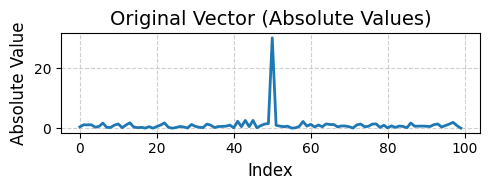

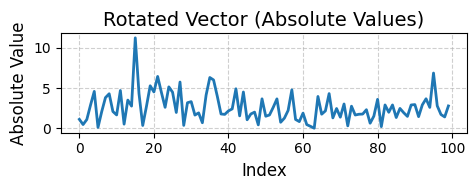

In [90]:
def get_orthogonal_matrix(size, mode="random", dtype=torch.float32, device="cpu"):
    """
    주어진 크기의 직교(orthogonal) 행렬을 생성하는 함수.
    랜덤 tensor를 QR Decomposition 한 Q tensor를 활용
    """
    if mode == "random":
        A = torch.randn(size, size, dtype=torch.float32, device=device)
        Q, R = torch.linalg.qr(A)
        Q *= torch.sign(torch.diag(R)).unsqueeze(0)
        return Q.to(dtype)
    else:
        raise ValueError(f"Unknown mode: {mode}")

dummy_vector = torch.randn(100)
dummy_vector[50] = 30

rotation_matrix = get_orthogonal_matrix(100)
rotated_vector = rotation_matrix @ dummy_vector

def plot_vector(vec, title):
    plt.figure(figsize=(5, 2))
    plt.plot(vec.abs().numpy(), linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Absolute Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

print(rotation_matrix)
print(torch.round(rotation_matrix @ rotation_matrix.T))
plot_vector(dummy_vector, 'Original Vector (Absolute Values)')
plot_vector(rotated_vector, 'Rotated Vector (Absolute Values)')

In [91]:
def quantize_tinyllama(
    model, weight_quant="per_tensor", act_quant="per_tensor", quantize_bmm_input=True, quantize_bits=4
):
    """
    TinyLlama 모델의 모든 Linear layer를 양자화 버전으로 변환.
    """
    for name, m in tqdm(model.model.named_modules()):
        if isinstance(m, torch.nn.Linear):
            # lm_head (최종 출력층)는 따로 처리되므로 건너뜀
            if "lm_head" in name:
                continue

            # 기존 Linear layer → 양자화 버전(W8A8Linear)으로 변환
            quantized_layer = W8A8Linear.from_float(
                m,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_bits=4  # 기본 4-bit weight quantization
            )

            # 기존 모델 구조 내에서 해당 layer를 교체하기 위한 부모 모듈 탐색
            parent_name = ".".join(name.split(".")[:-1])  # 예: 'transformer.layers.0.mlp'
            child_name = name.split(".")[-1]               # 예: 'fc1'

            if parent_name:
                # 부모 모듈 접근 후, 해당 자식 모듈을 quantized layer로 대체
                parent = model.model.get_submodule(parent_name)
                setattr(parent, child_name, quantized_layer)
            else:
                # 루트 수준에 있는 Linear layer라면 직접 교체
                setattr(model.model, child_name, quantized_layer)

    return model

## Layernorm ↔ Linear Fusion

실제 모델에서는 Rotation Matrix 사이에 Layernorm이 존재하는 경우가 많습니다.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1252/1*kC-cWBWDEZpkSCtYIUsj4w.png" width="300">
</p>

Normalization Layer의 영향으로 Rotation Matrix가 곱해지지 못해 정상적으로 제거되지 못하고 모델의 연산이 부정확해지는 문제가 발생할 수 있습니다.

따라서, Rotation 적용 이전에 Normalization Layer를 Linear Layer와 Fusion해야 합니다.

In [92]:
# Layer Norm Fusion Functions for TinyLlama
def fuse_ln_linear(layernorm, linear_layers):
    """
    LayerNorm(LN) 연산을 인접한 Linear Layer로 융합(Fusion)하는 함수.
    - LayerNorm의 weight, bias를 Linear layer의 weight, bias로 병합하여 Rotate가 가능한 형태로 변경
    """
    for linear in linear_layers:
        linear_dtype = linear.weight.dtype

        # (1) 새로운 Linear weight 계산
        # W' = W * γ  (γ는 LayerNorm의 weight)
        W_ = linear.weight.data.double()
        linear.weight.data = (W_ * layernorm.weight.double()).to(linear_dtype)

        # (2) 새로운 bias 계산
        # b' = b + W * β  (β는 LayerNorm의 bias)
        if hasattr(layernorm, "bias") and layernorm.bias is not None:
            if linear.bias is None:
                # bias가 없을 경우 0으로 초기화
                linear.bias = torch.nn.Parameter(
                    torch.zeros(linear.out_features, dtype=torch.float64)
                )
            linear.bias.data = linear.bias.data.double() + torch.matmul(
                W_, layernorm.bias.double()
            )
            linear.bias.data = linear.bias.data.to(linear_dtype)


def fuse_layer_norms_tinyllama(model):
    """
    TinyLlama 모델 구조에 맞게 LayerNorm을 인접 Linear Layer에 융합(Fuse)하는 함수.
    - Embedding, Attention, Feed-Forward, Final Norm 등 전체 구조에 적용.
    """
    # (1) 임베딩 레이어 정규화
    # 임베딩의 평균을 제거하여 중심화
    for W in [model.model.embed_tokens]:
        W_ = W.weight.data.double()
        W.weight.data = (W_ - W_.mean(dim=-1, keepdim=True)).to(W.weight.data.dtype)

    # (2) Transformer Block 단위로 LayerNorm Fusion 수행
    layers = [layer for layer in model.model.layers]

    for layer in layers:
        # (2-1) Attention 입력 LayerNorm을 q, k, v projection으로 융합
        fuse_ln_linear(
            layer.input_layernorm,
            [layer.self_attn.q_proj, layer.self_attn.k_proj, layer.self_attn.v_proj]
        )

        # (2-2) Attention 출력 후의 LayerNorm을 MLP의 게이트 및 업 projection으로 융합
        fuse_ln_linear(
            layer.post_attention_layernorm,
            [layer.mlp.gate_proj, layer.mlp.up_proj]
        )

        # (2-3) 융합 후, LayerNorm weight를 1로 초기화 (효과적으로 무시됨)
        W_norm = layer.input_layernorm.weight.data
        layer.input_layernorm.weight.data = torch.ones_like(W_norm)

        W_norm = layer.post_attention_layernorm.weight.data
        layer.post_attention_layernorm.weight.data = torch.ones_like(W_norm)

    # (3) 마지막 LayerNorm을 LM Head로 융합
    fuse_ln_linear(
        model.model.norm,
        [model.lm_head],
    )
    W_norm = model.model.norm.weight.data
    model.model.norm.weight.data = torch.ones_like(W_norm)

## [실습 5] Rotate Matrix 적용

QuaRot는 R1만 사용하여 Roation을 적용합니다.

그를 보완한 SpinQuant에서는 R2, R3, R4 등 다양한 Rotation Matrix를 적용하여 Quantization 정확도를 높입니다.

그러나, R2는 R1과 유사하게 적용 가능하고, R3와 R4는 On-line에서 구해지는 Matrix이기 때문에 구현 난이도를 낮추기 위해 QuaRot을 구현하는 것으로 하겠습니다.

QuaRot 혹은 SpinQuant 그림을 참고하셔서 각각의 연산에 R1이 어떻게 적용될 것인지 구현해보시기 바랍니다.

In [93]:
def rotate_model_weight(model, R1):
    """
    모델의 모든 Embedding 및 Linear Layer 파라미터에 회전 행렬(R1)을 적용하여
    Weight Space Rotation을 수행하는 함수.

    - QuaRot, SpinQuant 등의 기법에서 사용되는 핵심 단계로, 모델의 weight를 직교 행렬로 회전시켜 Outlier 완화
    - 회전 행렬 R1은 (hidden_dim × hidden_dim) 형태의 직교 행렬이어야 함.
    """
    for n, m in model.named_modules():
        ############### YOUR CODE STARTS HERE ###############
        # Pytorch에서 '@' 연산자는 행렬 곱 (dot product)을 의미합니다.
        # nn.Linear의 weight 파라미터는 W^T 형태로 저장되어 있다는 점을 유의해야 합니다.
        #
        # Shape 요약:
        #   Embedding  : (num_tokens, hidden_dim)
        #   Linear     : (out_channels, in_channels)
        #   Rotation R : (hidden_dim, hidden_dim)

        if isinstance(m, nn.Embedding):
            # Embedding Weight: (num_tokens, hidden_dim)
            W_ = m.weight.data
            m.weight.data = W_ @ R1

        if isinstance(m, nn.Linear):
            # Linear Layer: (out_features, in_features)
            if "o_proj" in n or "down_proj" in n:
                # Attention 출력 또는 FFN 다운프로젝션
                W_ = m.weight.data
                m.weight.data = R1.T @ W_
            else:
                # Q, K, V 프로젝션 및 FFN 게이트/업프로젝션
                W_ = m.weight.data
                m.weight.data = W_ @ R1

        ############### YOUR CODE ENDS HERE #################

        # GPU 메모리 캐시 정리
        torch.cuda.empty_cache()

In [94]:
print("\nOriginal 모델 성능 측정 중...")
llm_model.model_reset()
original_perplexity = llm_model.model_evaluate(data_width=16, group_size=128)
output_orig = llm_model.model(llm_model.testenc[:,:500].to(llm_model.model.device), output_hidden_states=True)
torch.cuda.empty_cache()


Original 모델 성능 측정 중...


evaluating...: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]



model perplexity: 7.75
model size: 2118.67 MiB


In [95]:
Q_BITS = 8

print("\nQuantization만 적용한 모델 성능 측정 중...")
llm_model.model_reset()
model = quantize_tinyllama(llm_model.model, quantize_bits=Q_BITS)
llm_model.model_change(model)
quantized_only_perplexity = llm_model.model_evaluate(data_width=Q_BITS, group_size=128)
torch.cuda.empty_cache()


Quantization만 적용한 모델 성능 측정 중...


291it [00:36,  7.88it/s]
evaluating...: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]



model perplexity: 43.13
model size: 1069.58 MiB


In [96]:
print("\nRotation + Quantization 적용한 모델 성능 측정 중...")
llm_model.model_reset()
fuse_layer_norms_tinyllama(llm_model.model)
hidden_size = llm_model.model.config.hidden_size
R1_random = get_orthogonal_matrix(hidden_size, mode="random", dtype=llm_model.model.dtype, device=llm_model.model.device)
rotate_model_weight(llm_model.model, R1_random)
model = quantize_tinyllama(llm_model.model, quantize_bits=Q_BITS)
llm_model.model_change(model)
rotation_quantized_perplexity = llm_model.model_evaluate(data_width=Q_BITS, group_size=128)
output_rotated = llm_model.model(llm_model.testenc[:,:500].to(llm_model.model.device), output_hidden_states=True)
torch.cuda.empty_cache()


Rotation + Quantization 적용한 모델 성능 측정 중...


291it [00:36,  7.88it/s]
evaluating...: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]



model perplexity: 38.52
model size: 1069.58 MiB


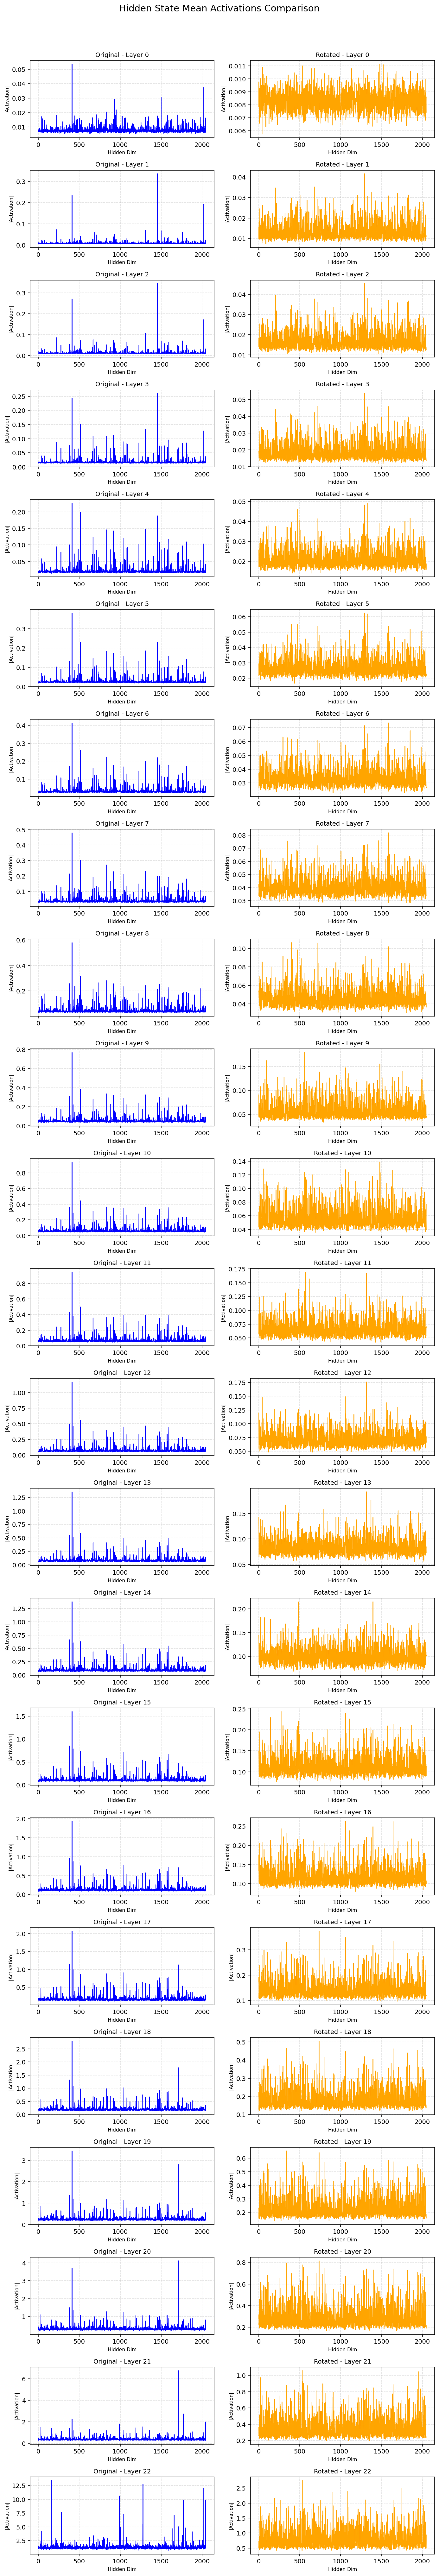

In [97]:
def plot_2d_layer_comparison(output1, output2, title1="Original", title2="Rotated", layer_range=None, seq_slice=(100, None)):
    hs1, hs2 = output1.hidden_states, output2.hidden_states
    n_layers = min(len(hs1), len(hs2))

    if layer_range is None:
        layer_range = range(n_layers)
    else:
        layer_range = [i for i in layer_range if i < n_layers]

    n_rows = len(layer_range)
    n_cols = 2

    plt.figure(figsize=(10, 2.5 * n_rows), dpi=140)
    plt.suptitle("Hidden State Mean Activations Comparison", fontsize=15, y=1.01)

    for i, layer_idx in enumerate(layer_range):
        # 첫 번째 모델 데이터
        data1 = hs1[layer_idx].detach().cpu().numpy()
        if len(data1.shape) == 3:
            data1 = data1[0]
        start, end = seq_slice
        data1 = data1[start:end, :]
        mean_act1 = np.mean(np.abs(data1), axis=0)

        # 두 번째 모델 데이터
        data2 = hs2[layer_idx].detach().cpu().numpy()
        if len(data2.shape) == 3:
            data2 = data2[0]
        data2 = data2[start:end, :]
        mean_act2 = np.mean(np.abs(data2), axis=0)

        # 왼쪽: Original
        plt.subplot(n_rows, n_cols, 2 * i + 1)
        plt.plot(np.arange(len(mean_act1)), mean_act1, color="blue", linewidth=1)
        plt.title(f"{title1} - Layer {layer_idx}", fontsize=10)
        plt.xlabel("Hidden Dim", fontsize=8)
        plt.ylabel("|Activation|", fontsize=8)
        plt.grid(True, linestyle="--", alpha=0.4)

        # 오른쪽: Rotated
        plt.subplot(n_rows, n_cols, 2 * i + 2)
        plt.plot(np.arange(len(mean_act2)), mean_act2, color="orange", linewidth=1)
        plt.title(f"{title2} - Layer {layer_idx}", fontsize=10)
        plt.xlabel("Hidden Dim", fontsize=8)
        plt.ylabel("|Activation|", fontsize=8)
        plt.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

plot_2d_layer_comparison(
    output_orig,
    output_rotated,
    title1="Original",
    title2="Rotated",
    layer_range=range(0, 24),
    seq_slice=(100, None)
)